In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative
import experiments.utils.drawing

In [2]:
metaseries = 14
# serieses = [1, 2, 3, 4, 5]
serieses = [81, 82, 83, 85]

# serie_color = {"IPA": "#ffff99", "FA2-low": "#a1dab4", "FA2-high": "#41b6c4", "RIM-high": "#253494"}
# yellow: ffff99

series_metadata = {
    81: {"label": "IPA", "color": "#d7191c"},
    82: {"label": "FA2-low", "color": "#a1dab4"},
    83: {"label": "FA2-high", "color": "#41b6c4"},
    # 44: {"label": "RIM-low", "color": ""},
    85: {"label": "RIM", "color": "#253494"},
}
pipeline_name = "nlp"

series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series in serieses
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [3]:
loaders

{81: <experiments.utils.parser.AdaptationParser at 0x7fdfdcb07070>,
 82: <experiments.utils.parser.AdaptationParser at 0x7fdfdcb070a0>,
 83: <experiments.utils.parser.AdaptationParser at 0x7fdfe6954a00>,
 85: <experiments.utils.parser.AdaptationParser at 0x7fe0ac254cd0>}

In [4]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 81 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 10,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 1,
    'benchmark_duration': 1,
    'beta': 0.5,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 5,
    'drop_limit': 20,
    'from_storage': [False, False, False],
    'gamma': 1e-06,
    'initial_active_model': [   'dinalzein-xlm-roberta-base-finetuned-language-identification',
                                'Helsinki-NLP-opus-mt-fr-en',
                                'sshleifer-distilbart-xsum-1-1'],
    'initial_batch': [1, 1, 1],
    'initial_cpu_allocation': [1, 2, 2],
    'initial_replica': [1, 1, 1],
    'latency_margin': 0,
    'logs_enabled': True,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib',
    'metaseries': 21,
    'mode': 'exponential',
    'model_name': ['nlp-li', 'nlp-trans

In [5]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [6]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{81: False, 82: False, 83: False, 85: False}

In [7]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [8]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Replica Changes
1. Total
2. Per node

In [9]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]

## Per Container Core changes
1. Total
2. Per Node

In [10]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

In [11]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()

ylabel = "Total Core"
print(total_core_changes)
print(total_core_changes.keys())

{81: {'nlp-li': [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 4, 4, 5, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'nlp-trans': [2, 16, 16, 16, 20, 24, 24, 24, 24, 24, 24, 24, 20, 20, 20, 20, 20, 20, 24, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 24, 24, 24, 24, 24, 24, 76, 76, 76, 76, 80, 80, 80, 84, 84, 88, 80, 80, 84, 84, 88, 88, 88, 88, 80, 76, 72, 72, 68, 72, 76, 76, 76, 76, 76, 76, 80, 80, 56, 60, 60, 52, 44, 40, 40, 40, 44, 40, 32, 32, 32, 20, 20, 20, 24, 24, 20, 20, 24, 24, 24, 24, 20, 24, 20, 20, 24, 20, 24, 20, 20, 20, 24, 24, 20, 20, 24, 24, 24, 24, 20, 20, 20, 24, 24], 'nlp-sum': [2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

## Accuracy Changes

In [12]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
ylabel = "Accuracy"
print(accuracy_changes)
print(accuracy_changes.keys())

{81: {'nlp-li': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'nlp-trans': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'nlp-sum': [0.0, 1.0, 1

## Maeseured p99 Latency


In [13]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

In [14]:
metric = "p99"  # [min, max, p99]
metrics_all = {}
for series in serieses:
    if not simulation_modes[series]:
        metric_columns = list(
            filter(lambda col: metric in col, per_second_results[series].columns)
        )
        metrics_all[series] = per_second_results[series][metric_columns]
        metrics_all[series] = metrics_all[series].to_dict(orient="list")
ylabel = "Second"
print(metrics_all)
print(metrics_all.keys())

{81: {'client_to_router_p99': [0.010438144207000732, 0.0041779899597167965, 0.004652998447418213, 0.0046389102935791016, 0.004267721176147461, 0.004694728851318359, 0.004573030471801758, 0.0044480466842651365, nan, 0.005824661254882813, 0.005009562969207764, 0.004161148071289062, 0.004117727279663086, 0.004467506408691407, 0.004669990539550781, 0.007170772552490235, 0.004890592098236084, 0.004690320491790772, 0.0049016356468200685, 0.005070219039916992, 0.0053259944915771485, 0.005062284469604492, 0.004919290542602539, 0.00547506332397461, 0.0051003098487854, 0.005193643569946289, 0.005115985870361328, 0.005669398307800293, 0.005731241703033447, 0.0054245138168334955, 0.005389268398284912, 0.005046987533569336, 0.005889892578125, 0.005290727615356445, 0.005498743057250976, 0.005328249931335449, 0.0053564500808715824, 0.005521845817565918, 0.005398023128509522, 0.005190527439117432, 0.006102666854858398, 0.005337285995483399, 0.005139853954315186, 0.005268609523773194, 0.005266046524047

## timeouts

In [15]:
ylabel = "% SLA Violations"
xlabel = "Experiments"
timeout_dics = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_dics[series] = {
            "e2e": (
                np.array(timeout_per_second[series]) / sum(sent_loads[series])
            ).tolist()
        }
        print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")

print(timeout_dics)
print(timeout_dics.keys())

1017 out of 14437
0 out of 14437
949 out of 14437
0 out of 14437
{81: {'e2e': [0.0, 0.0, 0.0, 0.0, 0.0, 6.926646810279144e-05, 6.926646810279144e-05, 6.926646810279144e-05, 0.0003463323405139572, 0.0001385329362055829, 6.926646810279144e-05, 0.0001385329362055829, 0.0002770658724111658, 0.0, 6.926646810279144e-05, 6.926646810279144e-05, 0.0, 0.0001385329362055829, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

# Paper ready figures

In [16]:
import importlib
import math


METRIC_TOTAL_CORE_CHANGES = "cost"
METRIC_ACCURACY_CHANGES = "accuracy"
METRIC_MEASURED_LATENCY = "latency"
# METRIC_TIMEOUT_DICS = "sla_violation"


metrics_metadata = {
    METRIC_TOTAL_CORE_CHANGES: {
        "title": "Cost",
        "ylabel": "Cost (cores)",
    },
    METRIC_ACCURACY_CHANGES: {
        "title": "Accuracy",
        "ylabel": "Accuracy",
    },
    METRIC_MEASURED_LATENCY: {
        "title": "Latency",
        "ylabel": "Latency (s)",
    },
    # METRIC_TIMEOUT_DICS: {
    #     "title": "SLA Violations",
    #     "ylabel": "SLA Violations (%)",
    # },
}
results = {
    METRIC_MEASURED_LATENCY: {},
    # METRIC_TIMEOUT_DICS: {},
    METRIC_TOTAL_CORE_CHANGES: {},
    METRIC_ACCURACY_CHANGES: {},
}

# for serie in timeout_dics.keys():
#     sla_violations = list(filter(lambda x: x is not None and not math.isnan(x), timeout_dics[serie]["e2e"]))
#     results[METRIC_TIMEOUT_DICS][serie] = sum(sla_violations)/len(sla_violations)  # Fixme: Is this correct?

for serie in metrics_all.keys():
    latencies = list(
        filter(
            lambda x: x is not None and not math.isnan(x), metrics_all[serie]["e2e_p99"]
        )
    )
    results[METRIC_MEASURED_LATENCY][serie] = sum(latencies) / len(latencies)

for serie in accuracy_changes.keys():
    results[METRIC_ACCURACY_CHANGES][serie] = sum(accuracy_changes[serie]["e2e"]) / len(
        accuracy_changes[serie]["e2e"]
    )

for serie in total_core_changes.keys():
    results[METRIC_TOTAL_CORE_CHANGES][serie] = sum(
        total_core_changes[serie]["total"]
    ) / len(total_core_changes[serie]["total"])


print(results)

{'latency': {81: 5.898904704643943, 82: 1.4699051237225542, 83: 4.544086844696608, 85: 2.988506213736539}, 'cost': {81: 56.52542372881356, 82: 47.45, 83: 213.86666666666667, 85: 72.06611570247934}, 'accuracy': {81: 1.6322033898305084, 82: 1.0, 83: 2.400000000000001, 85: 1.0}}


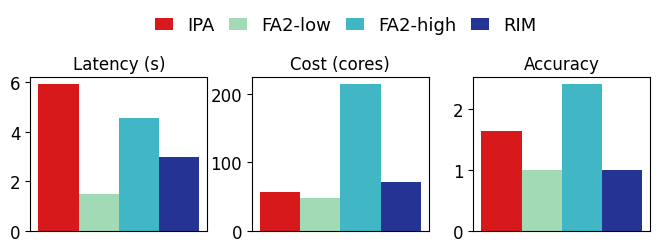

In [19]:
importlib.reload(experiments.utils.drawing)

experiments.utils.drawing.draw_cumulative_final(
    results,
    series_metadata,
    metrics_metadata,
    filename=f"{FIGURES_PATH}/metaseries-{metaseries}-{pipeline_name}-cul",
    bbox_to_anchor=(0.45, 1.5),
)